╔══<i><b>Alai-DeepLearning</b></i>════════════════════════════╗
###  &nbsp;&nbsp; **✎&nbsp;&nbsp;Week 13. RNN-Basis**
# Section . BPTT의 문제 개선하기



### _Objective_

1. Toy Dataset을 통해, 순환신경망(RNN)의 모델을 학습시켜 보도록 하겠습니다.<br>

╚═════════════════════════════════════════╝

In [0]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tqdm import tqdm

/Users/ksj/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)


## Toy Dataset) 복잡한 주기함수 Dataset

Noise가 있는 복잡한 시계열 데이터셋에서 다음 값을 예측하는 RNN 모델을 구성해보도록 하겠습니다.

In [0]:
def generate_timeseries(n_steps=50):
    m_x = np.random.uniform(0,10)
    xs = np.linspace(0, 5, n_steps+1)
    ys = np.array([0.5*np.sin(2*np.pi*(x+m_x))+ np.cos(3*np.pi/2*(x+m_x/4))
                   + np.random.uniform(-0.1,0.1) for x in xs])
    return ys[:-1],ys[-1]

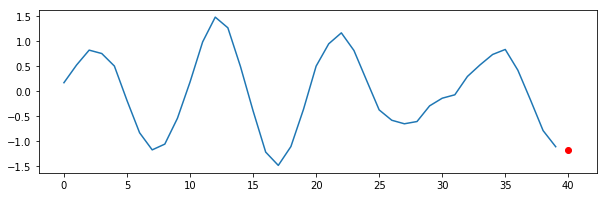

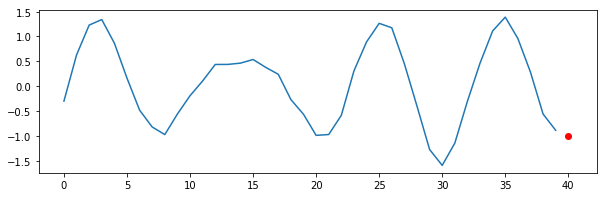

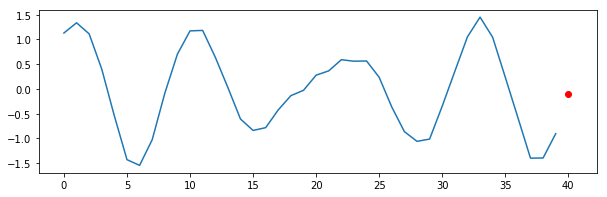

In [0]:
for _ in range(3):
    xs, ys = generate_timeseries(n_steps=40)
    timesteps = np.arange(len(xs)+1)
    plt.figure(figsize=(10,3))
    plt.plot(timesteps[:-1],xs)
    plt.scatter(timesteps[-1],ys,c='r')
    plt.show()

<br>


## 1. Orthogonal initialization

---

* CNN이나 MLP에서 기본적인 Initialization으로 Xaiver init이나 he init을 쓰는 것처럼<br> RNN에서는 기본적인 Initialization으로 orthogonal 초기화를 이용합니다.

### (1) Weight 초기화

BPTT는 아래와 같이 전파됩니다. 

$
\frac{\partial L}{\partial h_{(t-1)}} = 
\frac{\partial L}{\partial h^{(t)}} \frac{\partial h^{(t)}}{\partial a^{(t)}} \frac{\partial a^{(t)}}{\partial h^{(t-1)}} = \frac{\partial L}{\partial h^{(t)}}tanh'(a^{(t)}) W_{hh}
$

위 수식을 좀 더 단순하게 바라보기 위해 $tanh'(a^{(t)})$를 1이라 두겠습니다.<br>

$
\frac{\partial L}{\partial h_{(t-1)}} \approx
\frac{\partial L}{\partial h^{(t)}} W_{hh}\\
\frac{\partial L}{\partial h_{(t-n)}} \approx
\frac{\partial L}{\partial h^{(t)}} (W_{hh})^n
$

아래와 같이 N번의 Time Step을 진행하게 되면, $w_{hh}$가 N번 반복해서 행렬곱 연산이 진행되게 됩니다.<br>
$w_{hh}$가 초기에 어떤 값을 가지게 되는지에 따라 오차가 매우 크게 증폭될수도, 매우 작게 수렴될수도 있게 됩니다.

In [0]:
weight = np.random.normal(0,1,100).reshape(10,10)
weight

array([[-5.99583404e-01, -1.19288371e+00,  1.25743111e+00,
        -6.01863686e-01,  2.20969348e+00, -5.35022753e-01,
        -1.35474781e-02, -1.23280306e+00, -1.16748582e+00,
        -5.14065218e-01],
       [ 5.81654157e-01, -8.55803470e-02, -7.21236004e-02,
        -1.44794255e+00,  1.37342127e+00,  8.68865092e-02,
        -4.48598765e-01,  1.20879757e-01, -1.67568056e-01,
         5.47343974e-01],
       [ 3.44476830e-01,  8.02223549e-01,  2.67486323e-01,
         8.32945065e-01, -2.40000792e+00,  7.12128420e-03,
         5.57568200e-01,  2.43848421e-01,  9.93279095e-01,
         1.63872597e+00],
       [-2.49255117e-03,  6.12160919e-01, -1.75499689e-01,
         1.81658296e+00, -6.58901796e-01,  2.04199537e-01,
         1.57414833e-01, -5.07453506e-01, -5.19590927e-01,
         3.64828663e-01],
       [ 5.37296750e-01, -2.50029112e+00, -3.67001470e-01,
        -1.04329188e+00,  6.85629748e-02, -1.82681398e+00,
         3.90902422e-01, -1.64529949e-01,  5.73136651e-01,
        -1.

### (2) Weight Matrix의 크기

Weight Matrix 내 값들의 크기는 일반적으로 L2 Norm으로 표현할 수 있습니다. <br>
각 원소들의 제곱합의 제곱근으로 구합니다.

$$
||W||_2 = \sqrt{\sum_{i=1}^{m}\sum_{j=1}^{n} {W}_{i,j}^{2}}
$$

In [0]:
np.sqrt(np.sum(weight**2))

10.302244267358848

위의 수식을 Numpy에서는 아래와 같이 메소드를 제공합니다.

In [0]:
np.linalg.norm(weight)

10.30224426735885

행렬곱을 반복할수록 그 크기는 커지게 됩니다. 이렇게 행렬곱을 반복하면서 커지게 되면 <br>
Gradient도 덩달아 커지게 되면서 Gradient Exploding 현상이 발생할 수 있습니다.

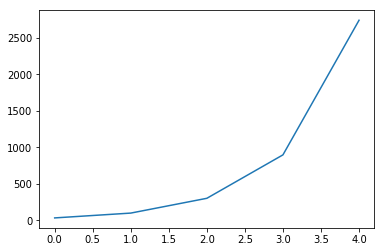

In [0]:
w = weight.copy()
w_norms = []
for i in range(5):
    w = np.matmul(weight,w)
    w_norms.append(np.linalg.norm(w))

plt.plot(w_norms)
plt.show()

역으로 행렬의 크기가 작으면, 반복할수록 그 크기가 잘아지게 됩니다. 이 경우는 아까와 반대로<br>
Gradient Vanishing 현상이 발생할 수 있습니다.

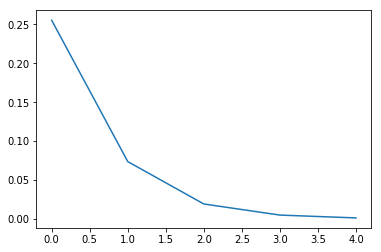

In [0]:
weight = np.random.normal(0,0.1,100).reshape(10,10) # 

w = weight.copy()
w_norms = []
for i in range(5):
    w = np.matmul(weight,w)
    w_norms.append(np.linalg.norm(w))

plt.plot(w_norms)
plt.show()

RNN에서는 Weight 특히, $w_{hh}$에 Gradient의 크기가 매우 민감하게 반응하는 문제가 있습니다.<br>
이러한 문제를 해결하기 위해 행렬곱을 반복하더라도 그 크기가 고정될 수 있도록 Orthogonal initialization을 제안합니다.

### (3) Orthogonal Initialization

우리는 이전 시간에 PCA를 배우면서 Eigen Vector와 Eigen Value를 분해하는 방법 중 하나인 <br>
Singular Value Decomposition을 배웠습니다. 

$$
X = U \Sigma V
$$

로 분해하는데, 이 때 U Matrix가 직교행렬입니다. <br> U Matrix의 각 행은 Eigen Vector로 구성되어 있는데, 특징 중 하나는 반복해서 곱하더라도 그 크기가 커지지 않는다는 점에 있습니다.<br>

In [0]:
weight = np.random.normal(0,1.,100).reshape(10,10) # 
orthogonal, _, _ = np.linalg.svd(weight, full_matrices=False)

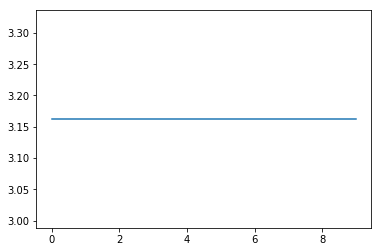

In [0]:
orth = orthogonal.copy()
orth_norms = []
for i in range(10):
    orth = np.matmul(orthogonal,orth)
    orth_norms.append(np.linalg.norm(orth))

plt.plot(orth_norms)
plt.show()

이로 인해 초기화를 Orthogonal Initialization으로 한다면, 초기 Gradient가 안정적으로 전파될 수 있다는 장점이 있습니다. 이로 인해 Keras에서 제공하는 RNN의 hidden weight들은 Orthogonal Initialization이 기본적으로 구현되어 있습니다.


<br>


## 2. Gradient Clipping

---

* 위에서 살펴봤듯, Gradient Vanishing 혹은 Exploding 문제는 RNN의 고질적인 문제입니다. Orthogonal Initialization은 초기 학습의 안정화에 도움이 되지만, 학습이 진행되다보면, weight의 값이 바뀌게 됨으로써, Orthogonal 특성을 잃어버리게 됩니다. 그러다보면 다시 Gradient에 문제가 발생할 수 있습니다.<br>
* 전통적으로 이러한 문제를 잡기위해 Gradient Clipping이라는 방법을 이용합니다.

![Imgur](https://i.imgur.com/OTID564.png)

### (1) Gradient 폭발 시의 문제 재현

recurrent weight($w_{hh}$) 초기화를 random normal 분포로 해줌으로써 Gradient Exploding 문제 시 어떻게 되는지 살펴보도록 하겠습니다.

In [0]:
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.layers import Input, SimpleRNN
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

모델은 아래와 같이 구성해보도록 하겠습니다.

In [0]:
K.clear_session()

# 모델 구성하기
n_inputs = 1
n_steps = 50
n_neurons = 200
n_outputs = n_inputs

inputs = Input(shape=(n_steps,n_inputs))
rec_init = tf.initializers.random_normal(0,1.)
hidden = SimpleRNN(n_neurons, 
                   recurrent_initializer=rec_init)(inputs)
output = Dense(1)(hidden)

model = Model(inputs,output)

model.compile(loss='mse', optimizer=Adam(lr=1e-4))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [0]:
def timeseries_generator(n_steps=50, batch_size=32):
    while True:
        batch_xs, batch_ys = [], []
        for _ in range(batch_size):
            x, y = generate_timeseries(n_steps)
            batch_xs.append(x[:,np.newaxis])
            batch_ys.append(y[np.newaxis])
        yield np.stack(batch_xs), np.stack(batch_ys)

batch_size = 16
train_gen = timeseries_generator(n_steps, batch_size)

hist = model.fit_generator(train_gen,
                           steps_per_epoch=100,
                           epochs=1)

Instructions for updating:
Use tf.cast instead.
100/100 [==============================] - 2s 21ms/step - loss: nan


위와 같이 Weight의 분포가 매우 클 경우에는 Loss 값이 NaN이 됨으로써, 동시에 Gradient도 NaN이 되게 됩니다.<br>
NaN 값은 보통 0으로 나누었을 때 혹은 지나치게 큰 값으로 폭발했을 경우 나타나게 됩니다.

### (2) Gradient Clipping 적용하기

Keras에서 모든 Optimizer는 기본적으로 gradient clipping을 제공해주고 있습니다.<br>


$
\hat g = \frac{\partial \epsilon}{\partial \theta} \\
\begin{cases}
\hat g \leftarrow \frac{threshold}{||\hat g||} \hat g, & \mbox{if } |\hat g| \ge threshold \\
\hat g \leftarrow \hat g, & \mbox{if } |\hat g| \lt threshold
\end{cases}
$

Gradient Clipping은 Graident의 최대 크기를 제한하고, Gradient가 최대치를 넘게 되면 Gradient의 크기를 지정한 최대 크기로 재조정하는 방법입니다. <br>
이러한 Gradient clipping은 최적화 알고리즘이 가야하는 방향은 그대로 유지하면서 업데이트되어야 하는 Step의 크기(learning rate)을 자동으로 조정합니다

In [0]:
K.clear_session()
n_inputs = 1
n_steps = 50
n_neurons = 200
n_outputs = n_inputs

inputs = Input(shape=(n_steps,n_inputs))
rec_init = tf.initializers.random_normal(0,1.)
hidden = SimpleRNN(n_neurons, 
                   recurrent_initializer=rec_init)(inputs)
output = Dense(1)(hidden)

model = Model(inputs,output)

# Optimizer에 clipnorm=0.1을 지정하는 것으로 
# gradient clipping 적용가능
model.compile(loss=tf.losses.mean_squared_error,
              optimizer=Adam(lr=1e-4, clipnorm=.1))

In [0]:
batch_size = 16
train_gen = timeseries_generator(n_steps, batch_size)

hist = model.fit_generator(train_gen,
                           steps_per_epoch=100,
                           epochs=10)

Epoch 1/10
100/100 [==============================] - 2s 18ms/step - loss: 2.3987
Epoch 2/10
100/100 [==============================] - 2s 16ms/step - loss: 2.1767
Epoch 3/10
100/100 [==============================] - 1s 15ms/step - loss: 2.1369
Epoch 4/10
100/100 [==============================] - 1s 15ms/step - loss: 2.0104
Epoch 5/10
100/100 [==============================] - 1s 15ms/step - loss: 1.9066
Epoch 6/10
100/100 [==============================] - 1s 13ms/step - loss: 1.7371
Epoch 7/10
100/100 [==============================] - 1s 14ms/step - loss: 1.6613
Epoch 8/10
100/100 [==============================] - 2s 18ms/step - loss: 1.5637
Epoch 9/10
100/100 [==============================] - 1s 12ms/step - loss: 1.6928
Epoch 10/10
100/100 [==============================] - 1s 12ms/step - loss: 1.5208


학습이 느리지만, 이전 Gradient Clipping이 없이 학습했을 때와는 달리 정상적으로 Loss가 줄어들게 됩니다.

<br>

## 3. Truncated BPTT

---

* 본질적으로 BPTT가 문제를 발생하는 부분은 긴 시계열 데이터를 다룰 때입니다.
긴 시계열을 다룰 때에는 Gradient을 계산하기 위해, 각 Time Step 별로 값을 저장해야 하기 때문에 메모리도 많이 필요하고 위에서 언급한 Gradient Exploding & Vanishing 문제가 발생하기도 매우 쉽기 때문입니다.<br>
* 위와 같은 문제를 근본적으로 해결하기 위해서는, 학습 시 Error의 전파를 특정 구간별로 자르는 truncated BPTT방법이 있습니다.

### (1) Truncated BPTT란?

![Imgur](https://i.imgur.com/XsoUlvO.png)

위 그림에서 살펴보면, RNN 계층을 길이 3개 단위로 학습할 수 있도록 역전파의 연결을 끊었습니다.<br>
이처럼 역전파의 연결을 잘라버리면, 우리는 3개보다 멀리 떨어진 input간의 관계에 대해서는 학습하지 않게 됩니다. 따라서 각각의 블록 단위로, 미래의 블록과는 독립적으로 Back Propagation을 수행할 수 있습니다.
<br>
여기서 반드시 기억할 점은 역전파의 연결은 끊어지지만, 순전파의 연결은 끊어지지 않는다는 점입니다. 그러므로 RNN을 학습시킬 때는 순전파가 연결된다는 점을 고려해야 합니다. 데이터를 '순서대로(sequential)' 입력해야 한다는 뜻입니다.

In [0]:
xs, _ = generate_timeseries(n_steps=1000)

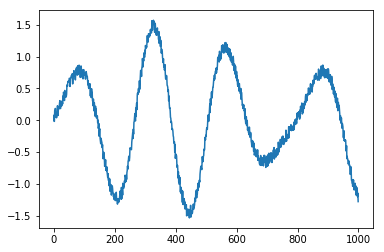

In [0]:
plt.plot(xs)
plt.show()

예를 들어 위와같이 1000 step이 넘는 긴 시계열을 학습해야한다고 봅시다. 위에서 바라볼 수 있듯 구역별로 작은 주기와 큰 주기가 결합되어 있기 때문에 보다 정밀하게 예측하기 위해서는 큰 범위의 시계열이 필요한 상황입니다.

### (2) Keras에서 Truncated BPTT 구현하기

keras에는 Truncated BPTT를 지원하기 위해, `stateful=True`를 지원합니다. <br>
이는 `RNNCell` 내의 State를 저장해두었다가, 다음 input이 들어왔을 때, 해당 state를 initial state로 이용하는 데에 있습니다.<br>
state를 이용하기 위해서는, batch_size를 고정시켜야 합니다. 여기서는 16으로 고정시키도록 하겠습니다.

In [0]:
K.clear_session()

# 모델 구성하기
n_inputs = 1
n_steps = 200
n_neurons = 200
batch_size = 16
n_outputs = n_inputs

inputs = Input(shape=(None,n_inputs), batch_size=batch_size)
hidden = SimpleRNN(n_neurons, stateful=True)(inputs)
output = Dense(1)(hidden)

model = Model(inputs, output)

model.compile(loss='mse',
              optimizer=Adam(lr=1e-4))

### (3) stateful을 위한 generator 구현하기

stateful하기 위해서는 batch를 구성할 때 batch의 순서가 timeseries을 따르도록 구성해야 합니다. batch간의 순서를 지키도록 아래와 같이 reshape와 transpose를 활용할 수 있습니다.

In [0]:
total_ts = []
final_ys = []
for _ in range(batch_size):
    timeseries, y = generate_timeseries(n_steps=1000)
    total_ts.append(timeseries)
    final_ys.append(y)
    
total_ts = np.stack(total_ts)
final_ys = np.stack(final_ys)[:,np.newaxis]

In [0]:
print("total_ts의 형태 : ",total_ts.shape)
print("final_ys의 형태 : ",final_ys.shape)

total_ts의 형태 :  (16, 1000)
final_ys의 형태 :  (16, 1)


이를 time step의 크기를 200만큼 truncate 하도록 하겠습니다.

In [0]:
train_xs = (total_ts.reshape((batch_size,-1,n_steps)))
print("train_xs의 형태 :", train_xs.shape)

train_xs의 형태 : (16, 5, 200)


이렇게 배치의 크기는 16개이고, block의 수는 5개, time step의 크기는 200로 나누어졌습니다.<br>
각 block의 예측값은 다음 block의 첫번째 값과 동일합니다. 그리고 마지막 block의 예측값은 `final_ys`에 저장되어 있습니다.

In [0]:
train_ys = np.concatenate([train_xs[:,1:,0], final_ys],axis=1)
print("train_ys의 형태 :", train_ys.shape)

train_ys의 형태 : (16, 5)


우리는 이제 학습을 block의 순서대로 학습을 진행하게 됩니다.<Br> 이를 보다 쉽게 하기 위해, transpose를 이용해 축을 이동하도록 하겠습니다.

In [0]:
train_xs = train_xs.transpose(1,0,2)[...,np.newaxis]
train_ys = train_ys.transpose(1,0)[...,np.newaxis]
print("train_xs의 형태 :", train_xs.shape)
print("train_ys의 형태 :", train_ys.shape)

train_xs의 형태 : (5, 16, 200, 1)
train_ys의 형태 : (5, 16, 1)


위와 같이 데이터를 자르는 과정을 메소드로 구현하면 아래와 같습니다.

In [0]:
def generate_stateful_sequences(batch_size=16, 
                                truncated_steps=50, 
                                n_steps=1000):
    total_ts = []
    final_ys = []
    for _ in range(batch_size):
        timeseries, y = generate_timeseries(n_steps)
        total_ts.append(timeseries)
        final_ys.append(y)

    total_ts = np.stack(total_ts)
    final_ys = np.stack(final_ys)[:,np.newaxis]        
    
    train_xs = (total_ts.reshape((batch_size,-1,truncated_steps)))
    train_ys = np.concatenate([train_xs[:,1:,0], final_ys],axis=1)
    
    train_xs = train_xs.transpose(1,0,2)[...,np.newaxis]
    train_ys = train_ys.transpose(1,0)[...,np.newaxis]
    return train_xs, train_ys

In [0]:
n_epochs = 30

for i in range(n_epochs):
    train_xs, train_ys = generate_stateful_sequences()

    model.reset_states() # state값을 0벡터로 초기화 시켜줌
    for batch_xs, batch_ys in zip(train_xs, train_ys):
        model.train_on_batch(batch_xs, batch_ys)
        
    if i % 10 == 0:
        model.reset_states() # state값을 0벡터로 초기화 시켜줌
        loss = model.evaluate(batch_xs, batch_ys, verbose=0)
        print("[{:2d} epoch] loss : {:.3f}".format(i, loss))

[ 0 epoch] loss : 0.047
[10 epoch] loss : 0.003
[20 epoch] loss : 0.005


> 위와 같은 방식으로 Truncated BPTT를 이용할 수 있습니다.